# Assignment 6: Reduction of dimensionality and recognition

In [79]:
import numpy as np
from matplotlib import pyplot as plt
from a6_utils import *
import cv2 as cv2
from UZ_utils import *
import os

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 200

## Exercise 1: Direct PCA method

The primary purpose of the PCA method is reduction of dimensionality. This means that
we want to find such a linear transformation of the input data that will describe the data
in a low dimensional orthogonal space (which can also be called a subspace) while losing
the minimal amount of information needed to reconstruct the data. A subspace is defined
by its basis vectors.

### A)
Solve the following assignment by hand for practice: You are given four points
A(3; 4), B(3; 6), C(7; 6) and D(6; 4). Calculate the eigenvectors and eigenvalues for
the given set of points.

In [5]:
import numpy as np
A = [[3,4],
[3,6],
[7,6],
[6,4]]

A = np.array(A)

U,v,d = np.linalg.svd(A)

print(U)
print(v)
print(d)


[[-0.35056636 -0.25351332 -0.68622263 -0.58475015]
 [-0.45095167 -0.76860929  0.14916864  0.42852196]
 [-0.65067933  0.26696221  0.581828   -0.40844065]
 [-0.5003621   0.5231653  -0.41027235  0.55462819]]
[14.12449298  2.73837505]
[[-0.70526298 -0.70894579]
 [ 0.70894579 -0.70526298]]


### B)
Write a script to calculate and visualize PCA from 2D data from the file points.txt
(the first column contains the x axis and the second column the y axis). Plot the
points and draw the representation of the Gaussian distribution using drawEllipse
from the supplementary material. Follow the Algorithm 1 to compute the eigenvectors
and eigenvalues of the PCA subspace

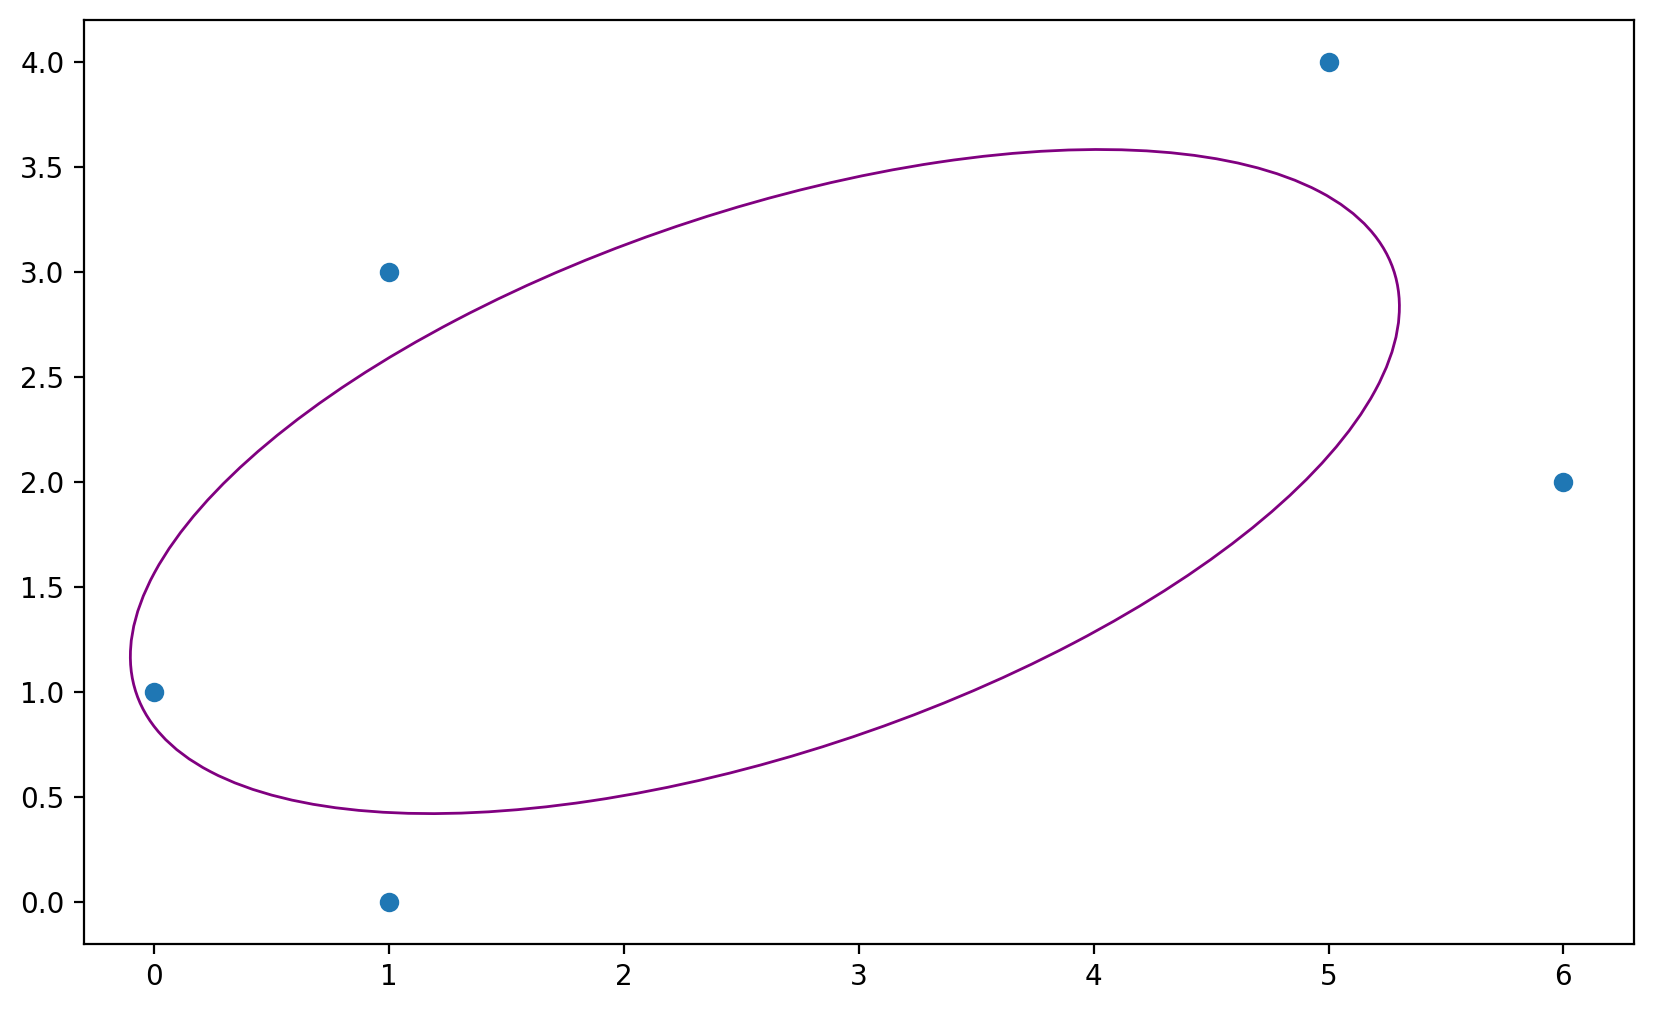

[[-0.92992935 -0.36773822]
 [-0.36773822  0.92992935]]
[8.18975683 1.61024317]


In [80]:
pointsorg = np.loadtxt("./data/points.txt")
pointsorg = pointsorg.T.copy()
points = pointsorg.copy()
plt.scatter(points[0,:], points[1,:])
mean = np.mean(points, axis=1)
points = points - mean[:, np.newaxis]
cov2 = (1/(points.shape[1] - 1)) * (points @ points.T)
drawEllipse(mean, cov2, n_std=1)
plt.show()


## svd of covariance matrix
S,V,D = np.linalg.svd(cov2)
print(S)
print(V)


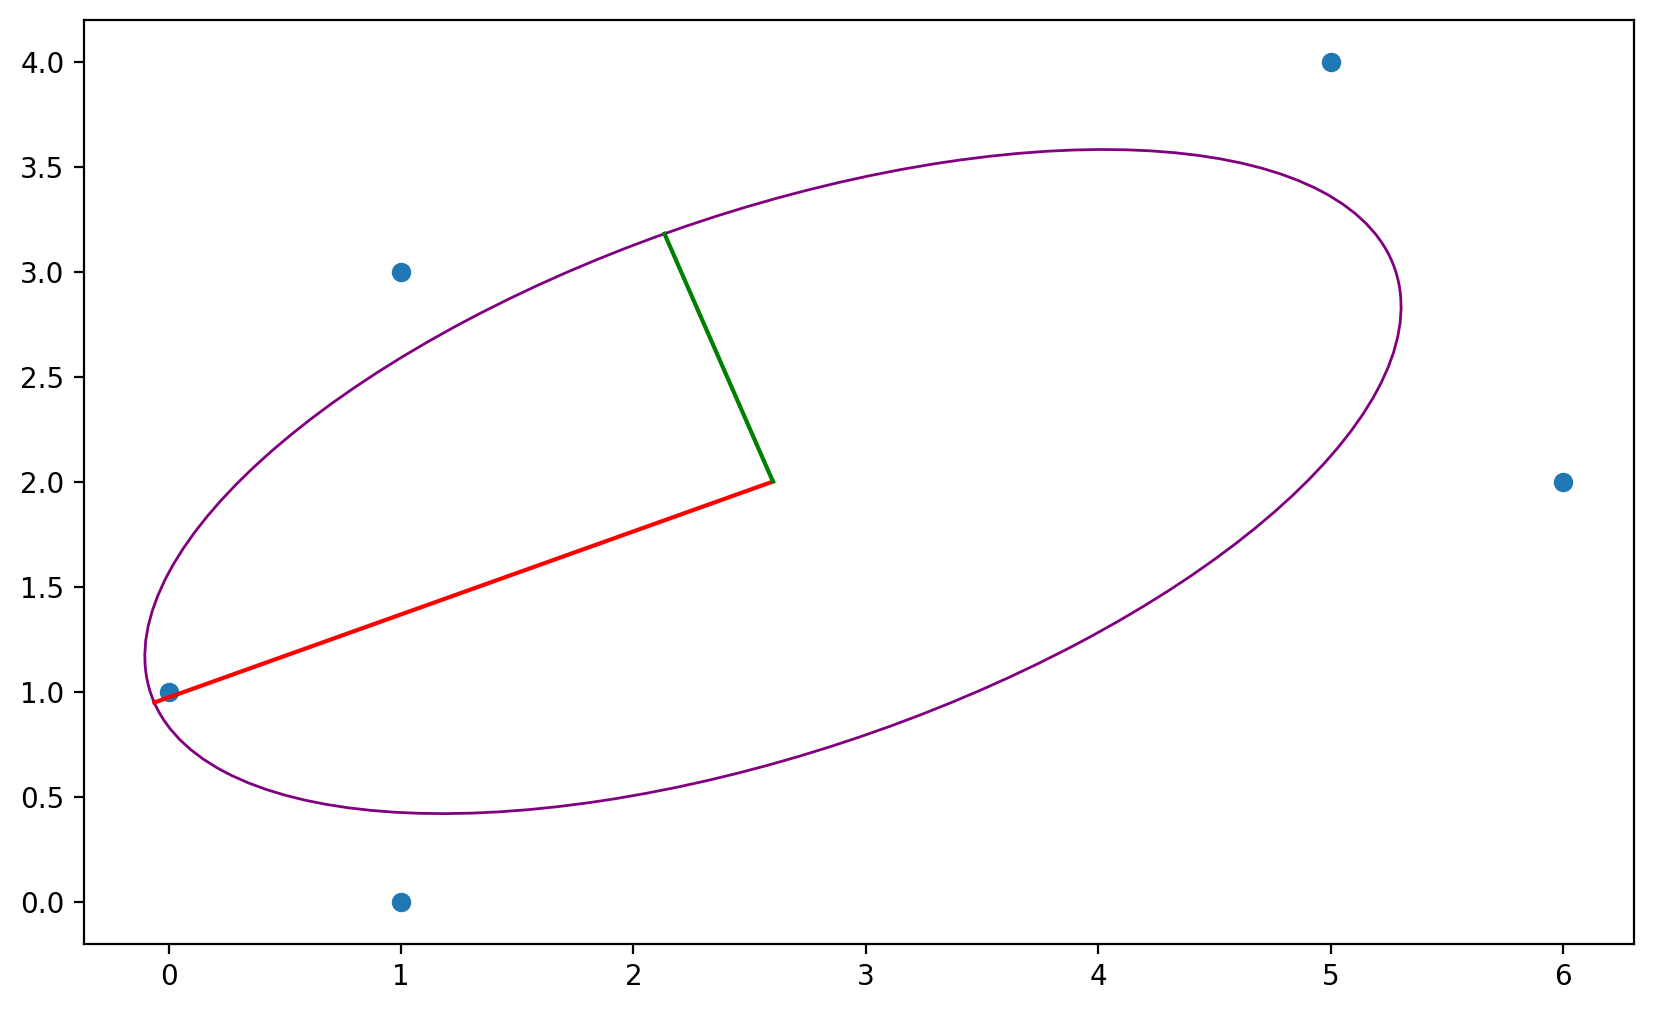

In [81]:
plt.scatter(pointsorg[0,:], pointsorg[1,:])
drawEllipse(mean, cov2, n_std=1)

## draw the eigenvectors
plt.plot([mean[0], mean[0] + S[0,0] * np.sqrt(V[0])], [mean[1], mean[1] + S[0,1] * np.sqrt(V[0])], color='red')
plt.plot([mean[0], mean[0] + S[1,0] * np.sqrt(V[1])], [mean[1], mean[1] + S[1,1] * np.sqrt(V[1])], color='green')
plt.show()

#### Question: What do you notice about the relationship between the eigenvectors and the data? What happens to the eigenvectors if you change the data or add more points?

#### Answer: the ratio between the vectors changes. Their values change. 

### D)
The eigenvalues represent the reconstruction error we incur if we discard the corresponding
eigenvector. Plot the cumulative graph of the eigenvalues and normalize
it so the largest value will be 1. From the graph determine how many percent of the
information will we retain if we discard the second eigenvector. To put it differently,
what percent of the variance is explained just by using the first eigenvector?

[8.18975683 1.61024317]
[0.83568947 0.16431053]


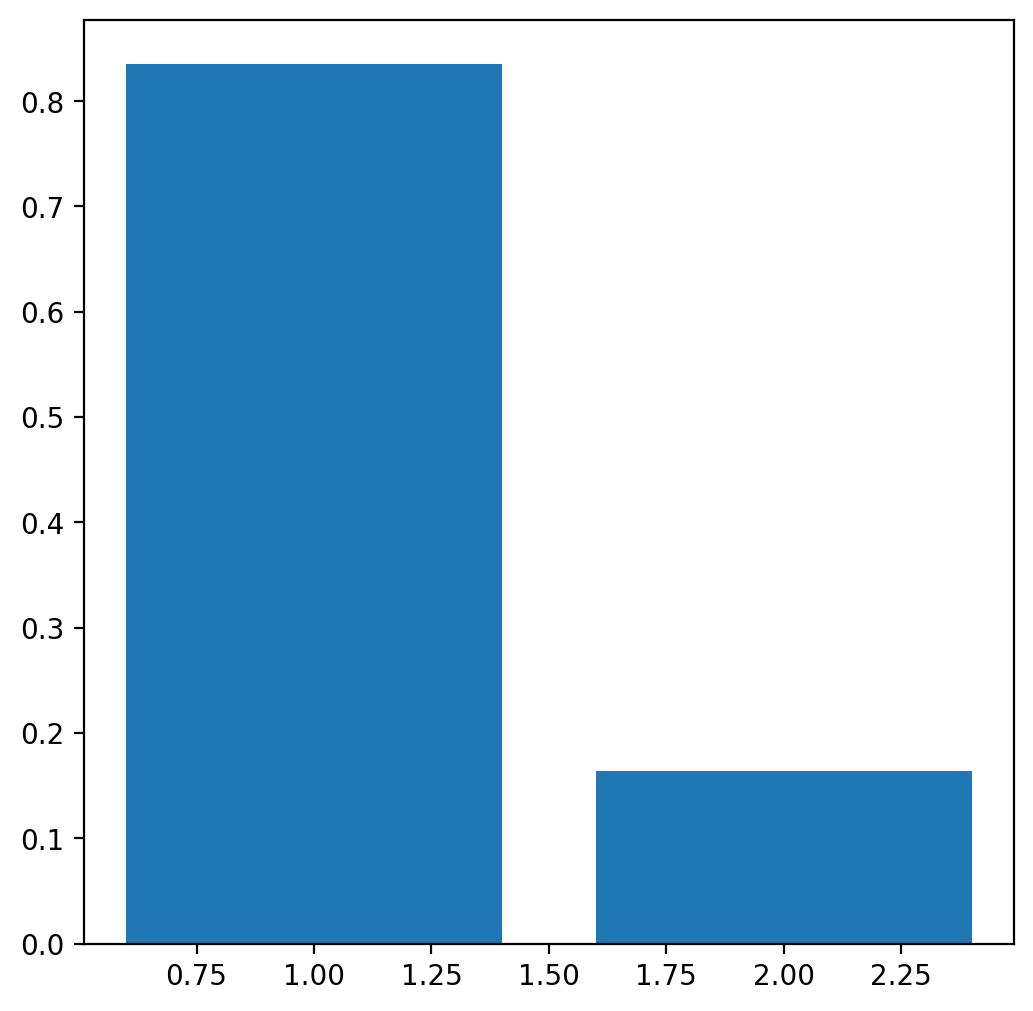

In [8]:
eigenvalues = V
print(eigenvalues)
eigenvalues = eigenvalues / np.sum(eigenvalues)

print(eigenvalues)
## bar plot the eigenvalues
plt.bar([1,2], eigenvalues)
plt.show()

# about 83 % of the variance is explained by the first eigenvector

### E)
Now remove the direction of the lowest variance from the input data. This means
we will project the data into the subspace of the first eigenvector. We can do this
by transforming the data into the PCA space then setting to 0 the components
corresponding to the eigenvectors we want to remove. The resulting points can
then be transformed back to the original space. Project each of the input points to
PCA space, then project them back to Cartesian space by multiplying them by the
diminished matrix U


[[-0.92992935]
 [-0.36773822]]


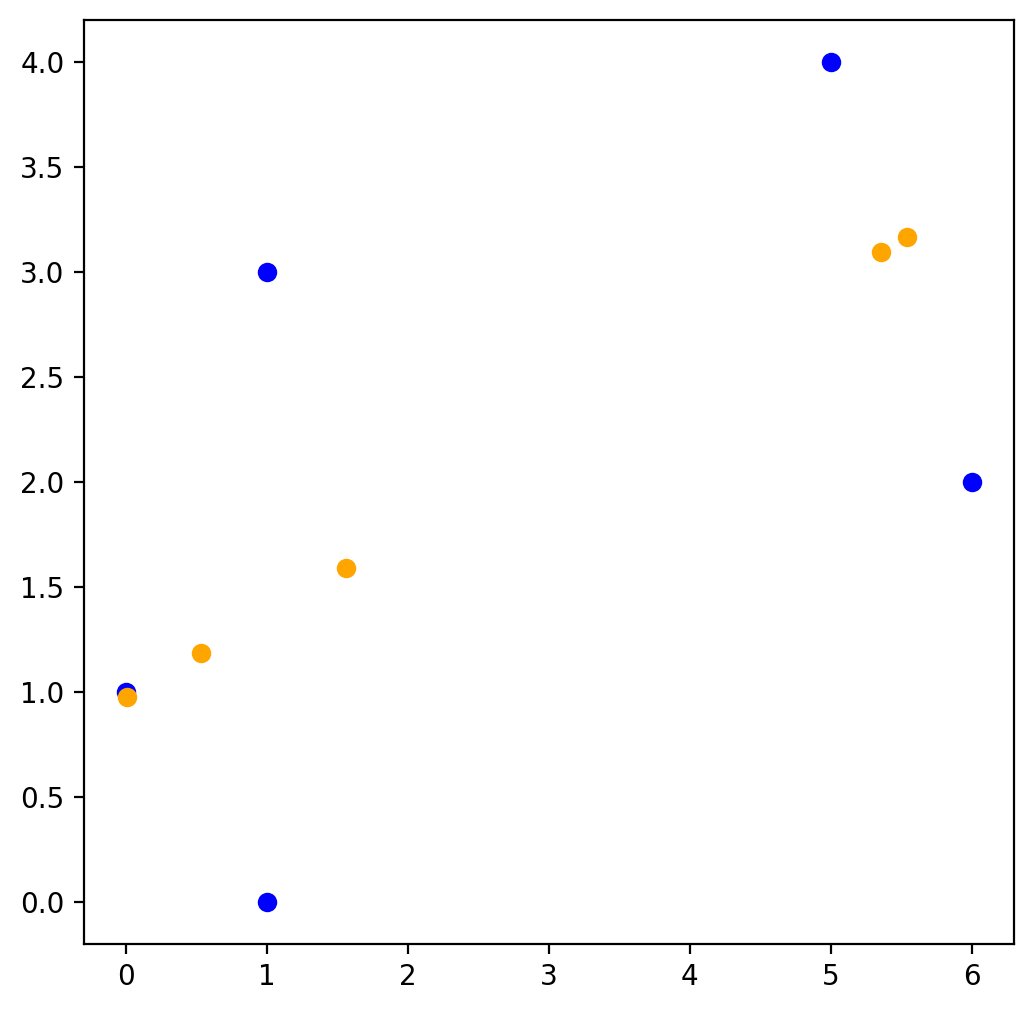

In [9]:
# U from first eigenvector
U = S[:,0:1]
# projection to subspace
y_i = U.T @ points
print(U)
# reconstruction
recon = U @ y_i
recon = recon + mean[:, np.newaxis]
plt.scatter(pointsorg[0,:], pointsorg[1,:], c='blue', label='original')
plt.scatter(recon[0,:], recon[1,:], c='orange', label='reconstruction')
plt.show()

##### Question: What happens to the reconstructed points? Where is the data projected to?

##### Answer: Data is projected to line that carries the eigenvector.

### F)
For the point q = [6; 6].T , calculate the closest point from the input data (using
Euclidean distance). Which point is the closest? Then, project all the points (including
q) to PCA subspace (calculated without q) and remove the variation
in the direction of the second vector. Calculate the distances again. Which point is
the closest to q now? Visualize the reconstruction.

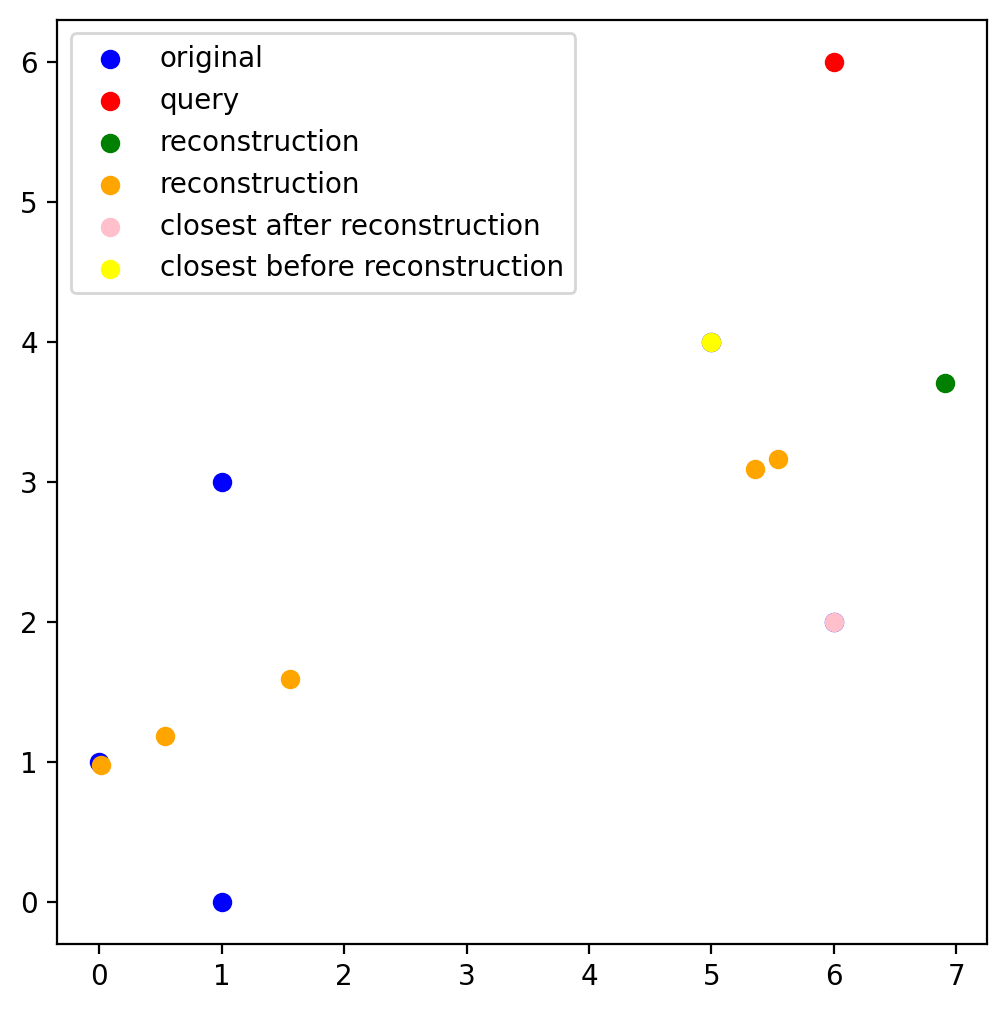

In [10]:
q = np.array([6,6])
# get the closest point
dist = np.linalg.norm(pointsorg - q[:, np.newaxis], axis=0)
idx = np.argmin(dist)
closest = pointsorg[:,idx]

## project the query point to the subspace
y_q = U.T @ (q - mean)
# reconstruct the query point
recon_q = U @ y_q + mean

#closes point to the query point
dist = np.linalg.norm(recon - recon_q[:, np.newaxis], axis=0)
idx = np.argmin(dist)
closest2 = pointsorg[:,idx]

plt.scatter(pointsorg[0,:], pointsorg[1,:], c='blue', label='original')
plt.scatter(q[0], q[1], c='red', label='query')
plt.scatter(recon_q[0], recon_q[1], c='green', label='reconstruction')
plt.scatter(recon[0,:], recon[1,:], c='orange', label='reconstruction')
plt.scatter(closest2[0], closest2[1], c='pink', label='closest after reconstruction')
plt.scatter(closest[0], closest[1], c='yellow', label='closest before reconstruction')
plt.legend()
plt.show()

## Exercise 2: The dual PCA method

When analyzing image data, the dimensionality can become very large (much larger than
the number of elements in the input), the direct method of computing eigenvectors we
used previously is no longer suitable. E.g. if we have 10000-dimensional data, this would
produce a covariance matrix of size 10000x10000. Here we are close to hitting the limits of
computer memory. As the number of data samples N is lower than the dimensionality we
can use the dual PCA method.

### A)
For our requirements it is necessary only to correctly calculate eigenvectors and
eigenvalues up to the scale factor. Therefore implement the dual method according
to the Algorithm 2 and test it using the data from points.txt. The first two
eigenvectors should be the same as with the Algorithm 1. The Algorithm 2 gives
you a larger matrix U, however, all eigenvectors but the first two equal to zero.

In [11]:
def dualPCA(points, n_components):
    """
    :param points: 2 x N matrix of points
    :param n_components: number of components to keep
    :return: U, eigenvalues, mean
    """
    X = points.T.copy()
    mean = np.mean(X, axis=1)
    #center the data
    X = X - mean[:, np.newaxis]
    # dual covariance matrix
    cov2 = (1/(X.shape[1] - 1)) * (X.T @ X)
    # SVD
    U,S,V_t = np.linalg.svd(cov2)
    # S = S + 1e-13
    #basis eigenvectors space
    U = X @ U @ np.sqrt(np.diag(1/(S * (X.shape[1]-1))))
    return U, S, V_t, mean 



points_2d = np.loadtxt("./data/points.txt")

U, S, V_t, mean = dualPCA(points_2d, 1)
print(U)
a = [[-0.92992935, -0.36773822],[-0.36773822,  0.92992935]]

[[ 9.29929353e-01 -3.67738219e-01 -1.38575601e-09  3.31219041e-08
   1.82942103e-08]
 [ 3.67738219e-01  9.29929353e-01  4.95269204e-09  1.27043818e-08
   3.22049582e-08]]


### B)
Project the data from the previous assignment to the PCA space using matrix U,
and then project the data back again in the original space. If you have implemented
the method correctly, you will get the original data (up to the numerical error).

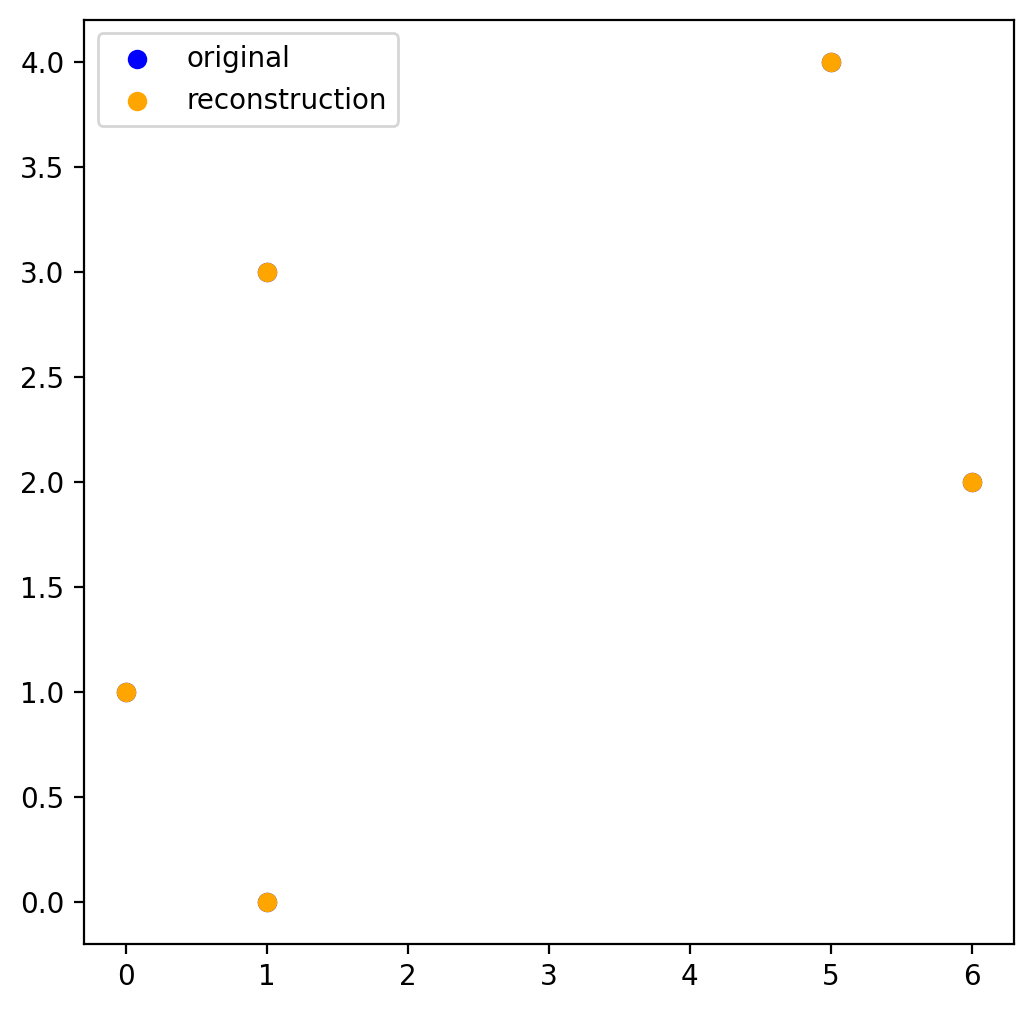

In [12]:
## project to PCA space
y_i = U.T @ (points_2d.T - mean[:, np.newaxis])
## reconstruct
recon = U @ y_i + mean[:, np.newaxis]
recon = recon
plt.scatter(points_2d[:,0], points_2d[:,1], c='blue', label='original')
plt.scatter(recon[0,:], recon[1,:], c='orange', label='reconstruction')
plt.legend()
plt.show()


## Exercise 3: Image decomposition examples

Here we will use the dual PCA method on a computer vision problem. In the supplementary
material there are three series of images. Each series contains 64 images of a face
under different lighting conditions. Your task will be to analyze each series using the PCA
method.

### A)
Data preparation: Firstly, we have to formulate the problem in a way that is
compatible with the PCA method. Since PCA operates on points in space, we can
represent a grayscale image of size m x n as a point in mn-dimensional space if we
reshape it into a vector. Write a function that reads all the images from one of the
series transforms them into grayscale reshapes them using np.reshape and stacks
the resulting column vectors into a matrix of size mn x 64.

In [13]:
def prepare_data(data_path):
  images = np.array([])
  for image in os.listdir(data_path):
    img = imread_gray(data_path + image)
    img = np.reshape(img, (8064,1))
    #append to the images
    if images.size == 0:
      images = img
    else:
      images = np.hstack((images, img))
  return images
data = prepare_data("./data/faces/1/")
print(data.shape)

(8064, 64)


### B)
Using dual PCA: Use dual PCA on the vectors of images. Write a function that
takes the matrix of image vectors as input and returns the eigenvectors of the PCA
subspace and the mean of the input data.

Transform the first five eigenvectors using the np.reshape function back into a
matrix and display them as images. What do the resulting images represent (both
numerically and in the context of faces)?

In [14]:
data = prepare_data("./data/faces/1/")
U, S, V_t, mean = dualPCA(data.T, 1)


(8064, 64)


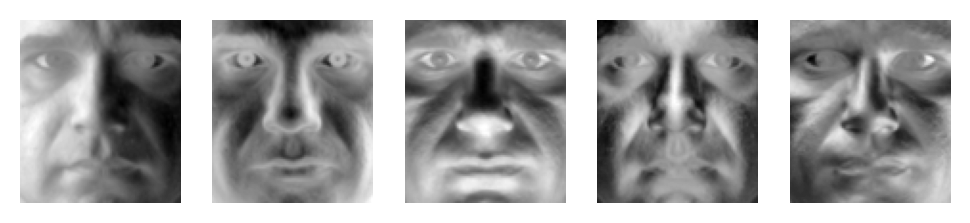

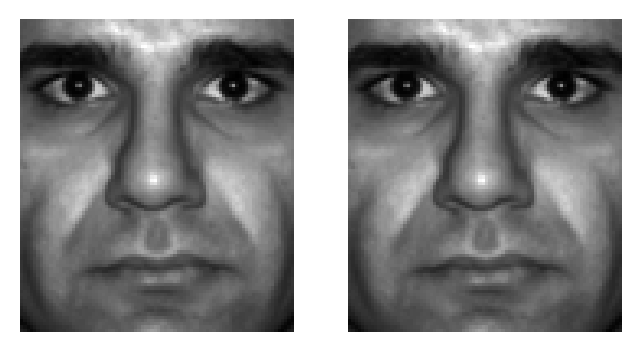

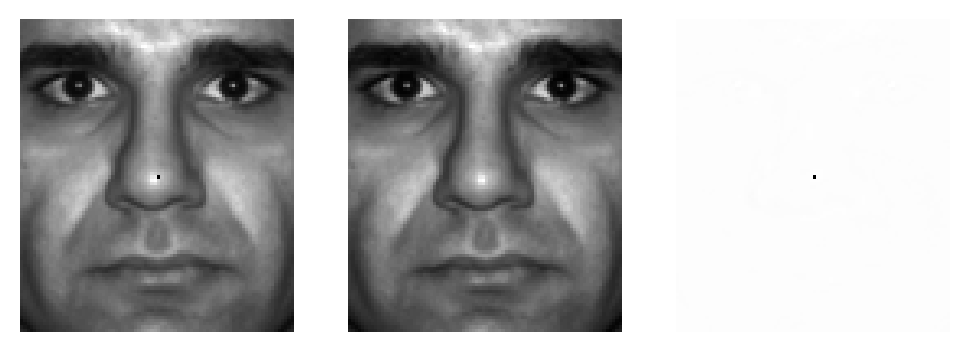

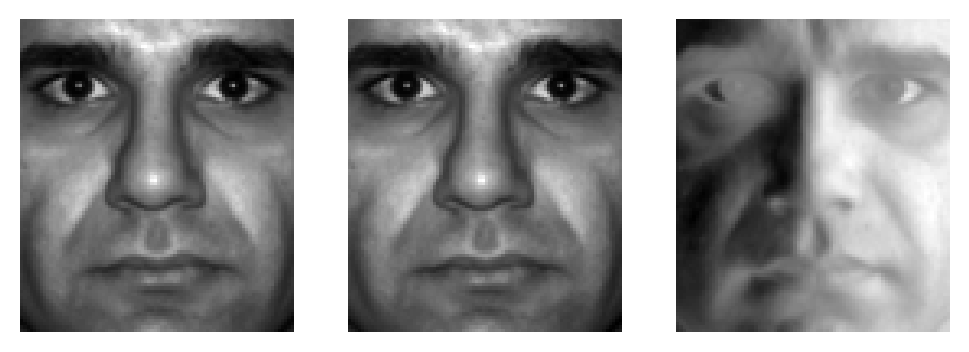

In [15]:
# eigenvectors = U
image_size = (96,84)
print(U.shape)

# take first 5 eigenvectors
# plot the eigenvectors
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(U[:,i].reshape(image_size), cmap='gray')
  plt.axis('off')
plt.show()

# project the first image to the subspace
y_i = U.T @ (data[:,0] - mean)
# reconstruct the first image
recon = U @ y_i + mean

plt.subplot(1,3,1)
plt.imshow(data[:,0].reshape(image_size), cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(recon.reshape(image_size), cmap='gray')
plt.axis('off')
plt.show()
# THE RESULT IS THE SAME

image = data[:,0].copy()
image[4074] = 0 

# project the first image to the subspace
y_i = U.T @ (image - mean)
# reconstruct the first image
recon = U @ y_i + mean

plt.subplot(1,3,1)
plt.imshow(image.reshape(image_size), cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(recon.reshape(image_size), cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow((image - recon).reshape(image_size), cmap='gray')
plt.axis('off')
plt.show()

image = data[:,0]
# project the first image to the subspace
y_i = U.T @ (image - mean)
y_i[0] = 0
# reconstruct the first image
recon = U @ y_i + mean

plt.subplot(1,3,1)
plt.imshow(image.reshape(image_size), cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(recon.reshape(image_size), cmap='gray')
plt.axis('off')
# plot difference
plt.subplot(1,3,3)
plt.imshow((image - recon).reshape(image_size), cmap='gray')
plt.axis('off')
plt.show()

##### Question: What do the resulting images represent (both numerically and in the context of faces)?

##### Answer: 5 most simmilar pictures (distance) to all the other images.

### C)
Effect of the number of components on the reconstruction: Take a random
image and project it into the PCA space. Then change the vector in the PCA space
by retaining only the first 32 components and setting the remaining components to
0. Project the resulting vector back to the image space and display it as an image.
Repeat the procedure for the first 16, 8, 4, 2, and one eigenvector. Display the
resulting vectors together on one figure. What do you notice?

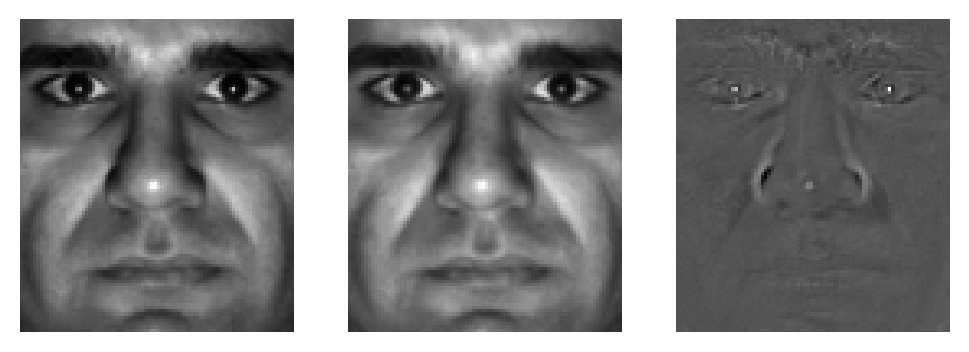

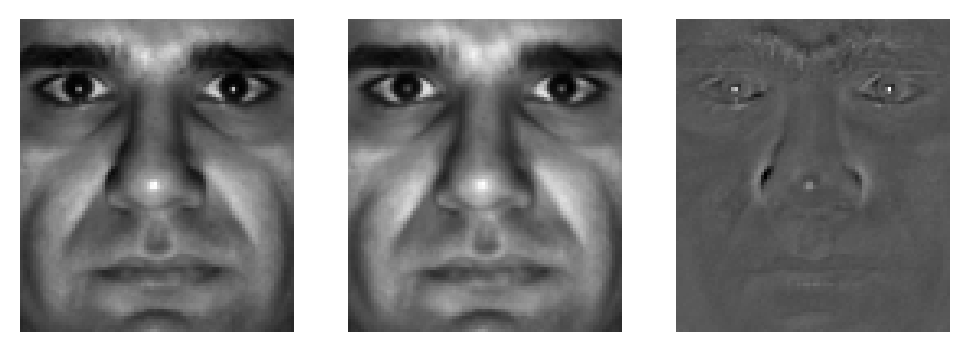

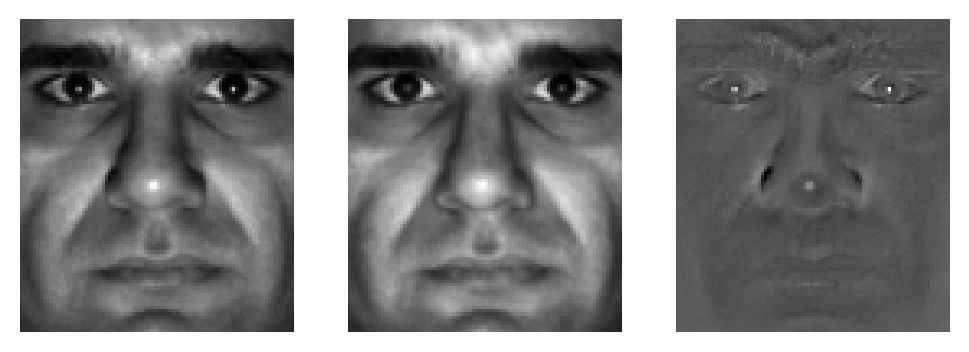

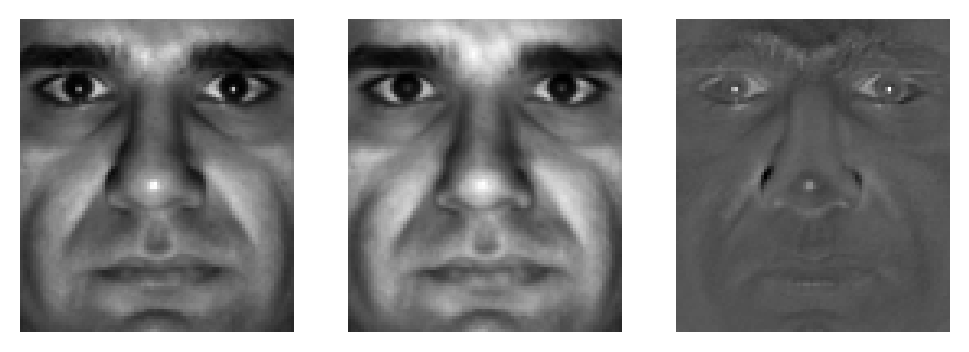

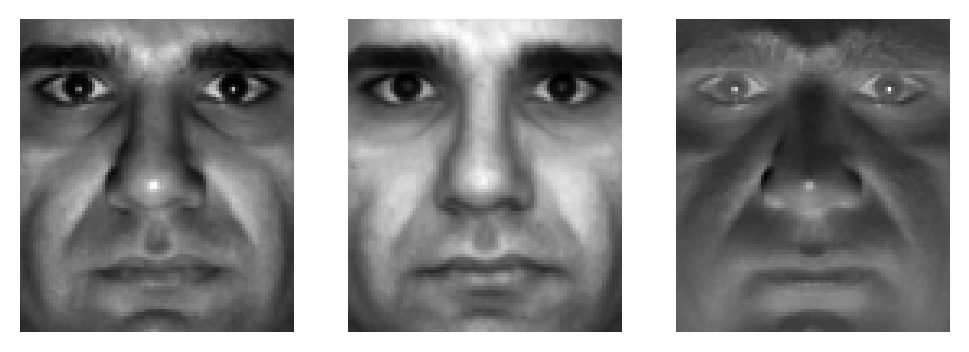

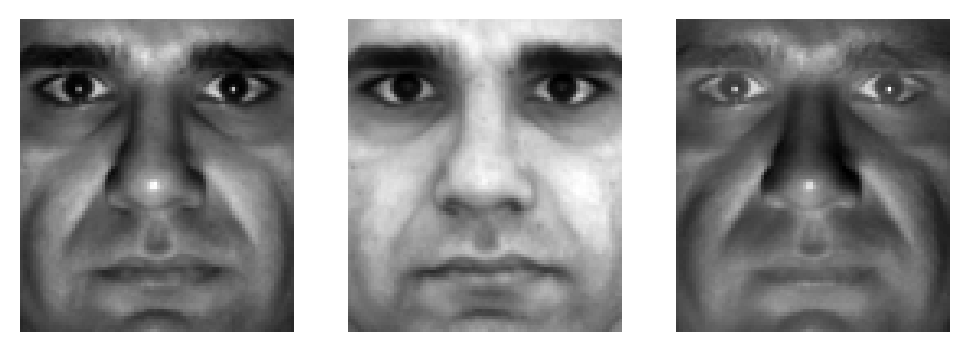

In [16]:
values = [32,16,8,4,2,1]


for value in values:
  # take a random picture from the dataset
  image = data[:,1].copy()
  # project the first image to the subspace
  y_i = U.T @ (image - mean)
  # set every value from the first value to 0
  y_i[value:] = 0
  # y_i[:value] = 0
  # reconstruct the first image
  recon = U @ y_i + mean

  plt.subplot(1,3,1)
  plt.imshow(image.reshape(image_size), cmap='gray')
  plt.axis('off')
  plt.subplot(1,3,2)
  plt.imshow(recon.reshape(image_size), cmap='gray')
  plt.axis('off')
  # plot difference
  plt.subplot(1,3,3)
  plt.imshow((image - recon).reshape(image_size), cmap='gray')
  plt.axis('off')
  plt.show()



### D)
Each eigenvector holds
information that defines some aspect of the PCA space. By changing the values of
a vector in a periodic way, we can observe how different weights for an eigenvector
affect the reconstructed image.
Use the second series of images for this task. Take the average photo that you
compute based on all images in the series. Project the average image to PCA space. Then, select one of the more important eigenvectors and manually set its
corresponding weight in the projected vector to some value of your choice. Project
the modified vector back to image space and observe the change.
In order to see the changes easier, write a script that goes over a range of values
for your selected eigenvector. To smoothly change the values, use np.sin and
np.linspace as well as some scaling factor x to show the differences more strongly.
Also, use plt.draw in combination with plt.pause to display the results as an
animated sequence of images.

C:\Users\Blaz\AppData\Local\Temp\ipykernel_3764\2796810385.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


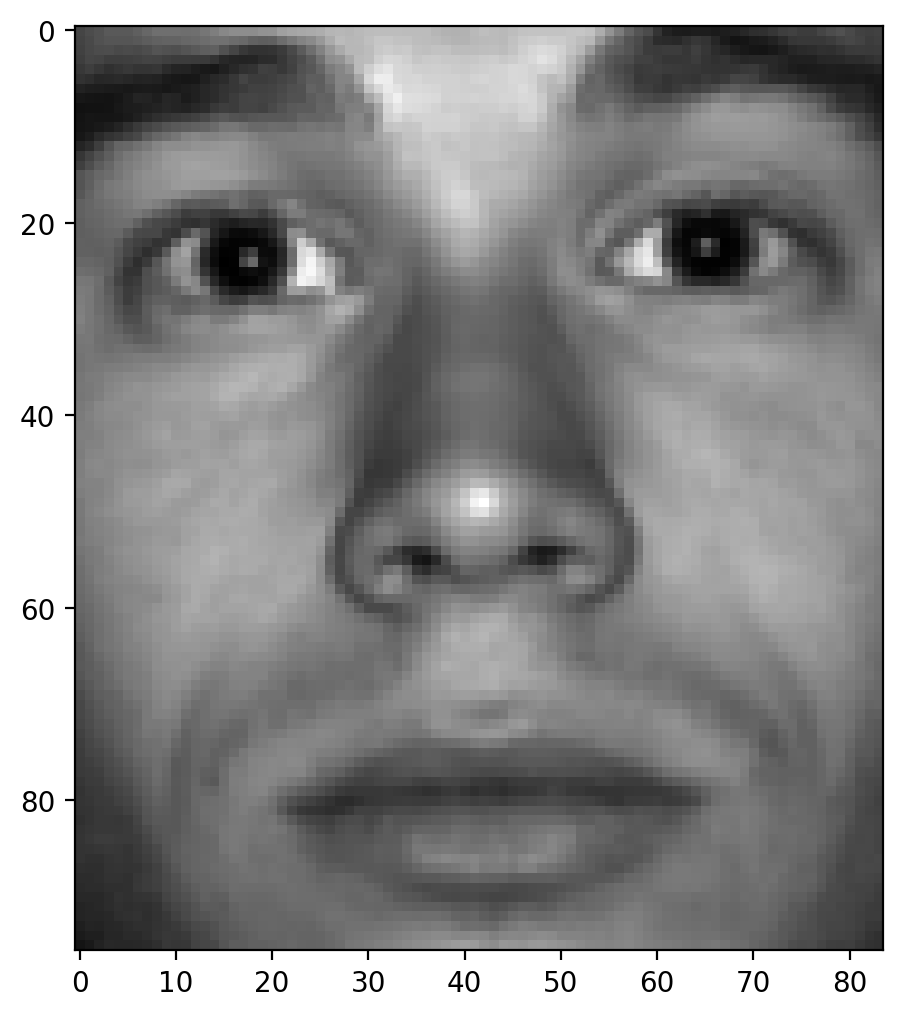

In [17]:
image_size = (96,84)
# get the average face from the dataset
data = prepare_data("./data/faces/2/")

fig = plt.figure()
view = fig.add_subplot(111)
plt.ion()
fig.show()

# mean of the data
mean = np.mean(data, axis=1)
# pick image 1
image = data[:,0]
x = np.linspace(-10, 10, 100)
sinx = np.sin(x)
cosx = np.cos(x)
U, S, V_t, mean = dualPCA(data.T, 1)

for sin,cos in zip(sinx, cosx):
  # project the first image to the subspace space. 
  # The first eigenvector is the most important one
  y_i = U.T @ (image - mean)
  # Then, select one of the more important eigenvectors and manually set its corresponding weight in the projected vector to some value of your choice. 
  # For example, you can set the weight of the first eigenvector to 0.
  y_i[0] = sin * 3000
  y_i[1] = cos * 3000
  # reconstruct the first image
  # Project the modified vector back to image space and observe the change.
  recon = U @ y_i + mean
  recon = np.reshape(recon, image_size)
  view.clear()
  view.imshow(recon, cmap='gray')
  plt.pause(0.05)
  fig.canvas.draw()

#### E)
Reconstruction of a foreign image: The PCA space is build upon
an array of data. In this task we will check the effect that the transformation to PCA
space has on an image that is not similar to the images that were used to build the
PCA space. Write a script that computes the PCA space for the first face dataset.
Then load the image elephant.jpg, reshape it into a vector and transform it into
the precalculated PCA space, then transform it back to image space. Reshape the
resulting vector back to an image and display both the original and the reconstructed
image. Comment on the results


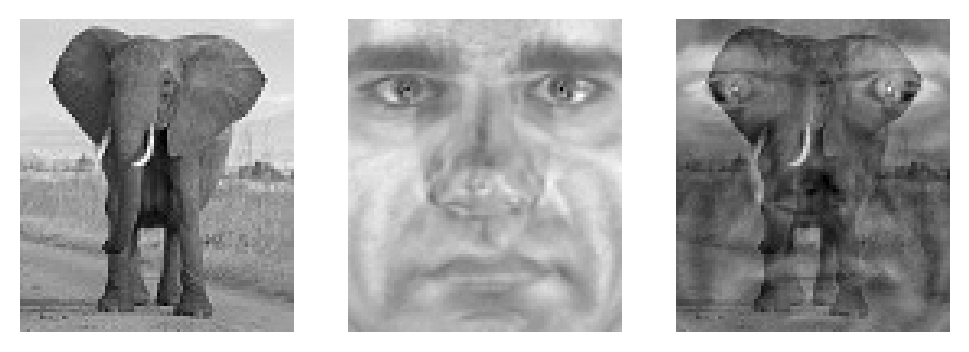

In [18]:
## PCA SPACE for first dataset
data = prepare_data("./data/faces/1/")
U, S, V_t, mean = dualPCA(data.T, 1)

elephant = imread_gray("./data/elephant.jpg")
elephant = np.reshape(elephant, (8064)).T
## project to PCA space
y_i = U.T @ (elephant - mean)
## reconstruct
recon = U @ y_i + mean

plt.subplot(1,3,1)
plt.imshow(elephant.reshape(image_size), cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(recon.reshape(image_size), cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow((elephant - recon).reshape(image_size), cmap='gray')
plt.axis('off')
plt.show()

### G)
Linear discriminant analysis: Based on the instructions from the
lecture slides (Subspace-based recognition) implement the LDA algorithm and apply
it to our face database. Make sure that you also address the problem of singularities
in high-dimensional data using appropriate pre-processing (also described in the
lecture slides). Visualize all the image samples in the 2D PCA subspace and the
LDA subspace with different colors for each class to demonstrate that the LDA
subspace better separates classes.

(192, 192)
(8064, 192)


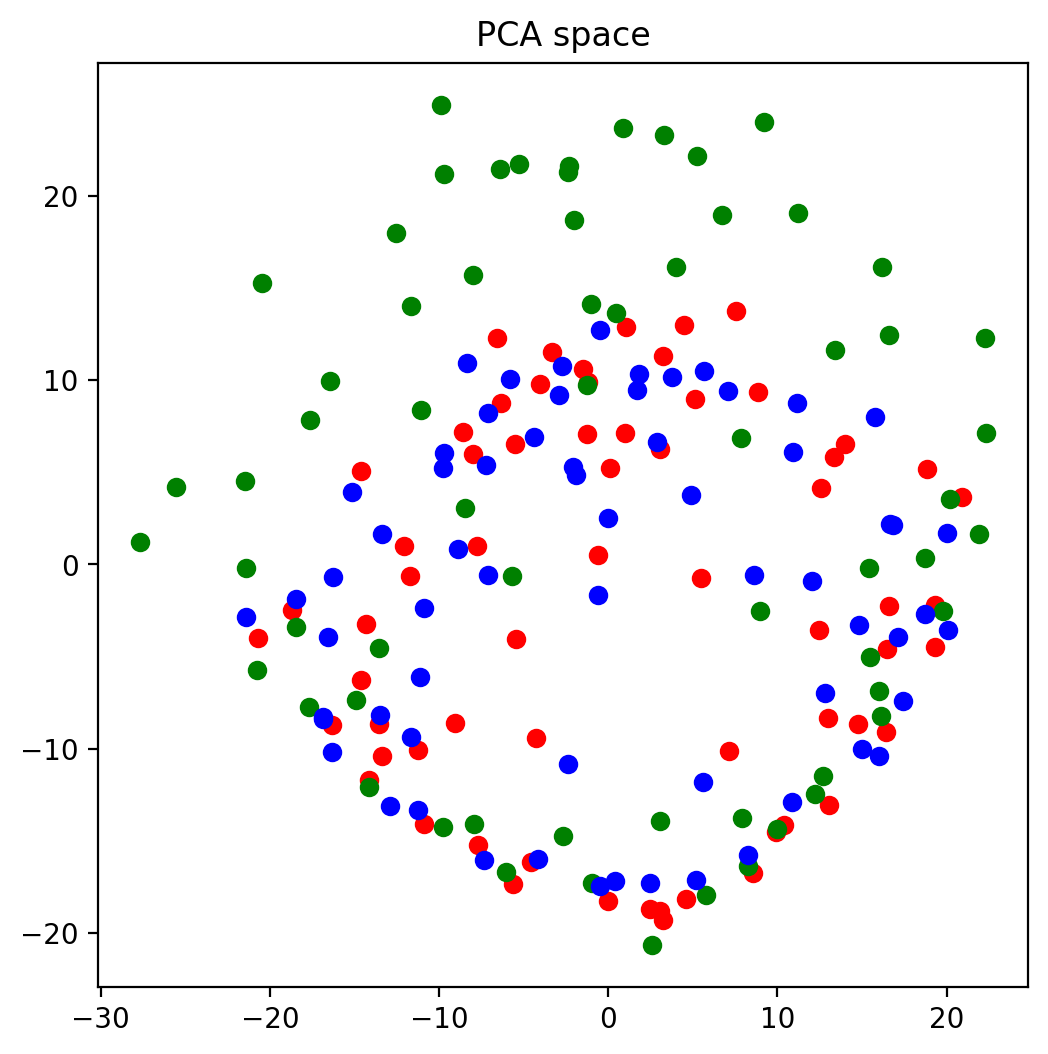

C:\Users\Blaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


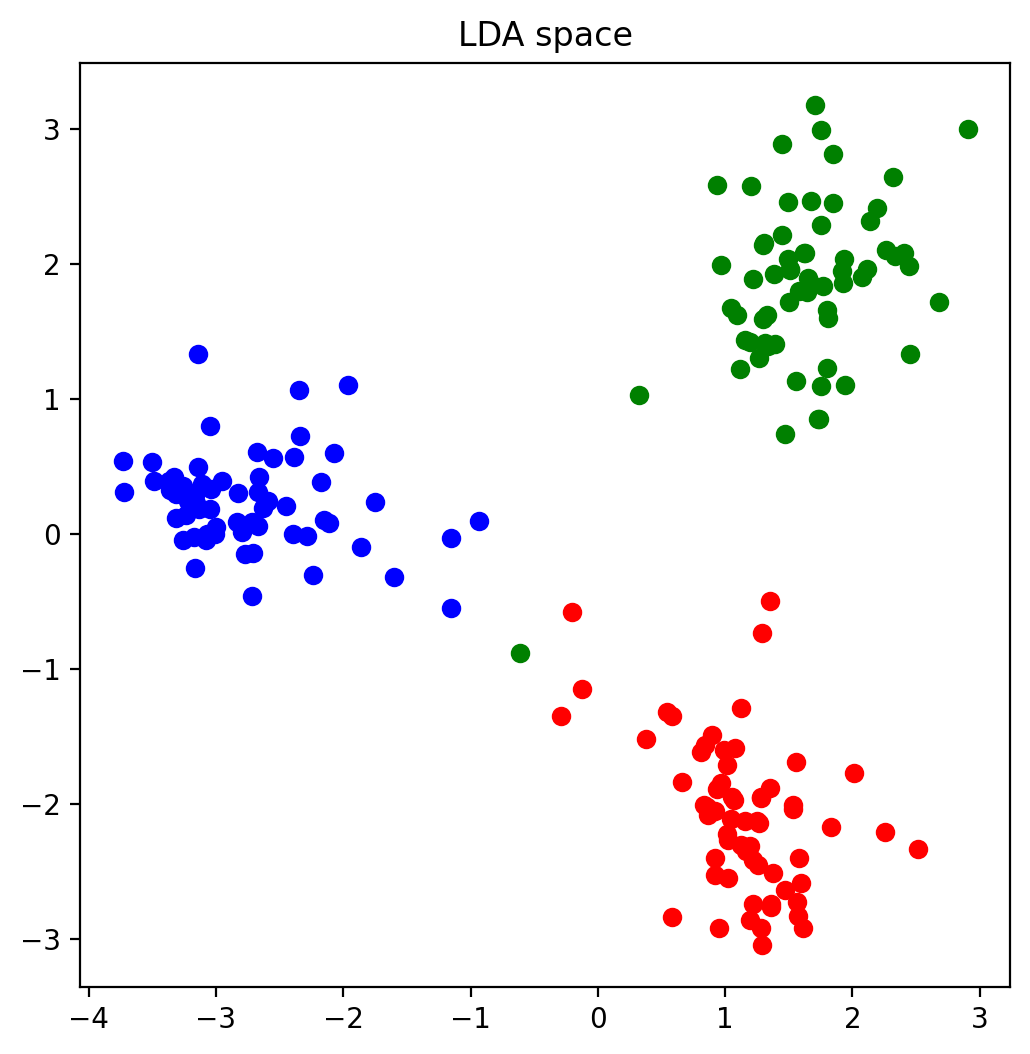

In [51]:
faces_1 = prepare_data("./data/faces/1/")
faces_2 = prepare_data("./data/faces/2/")
faces_3 = prepare_data("./data/faces/3/")
# concatenate the datasets
faces = np.hstack((faces_1, faces_2, faces_3))
# compute the PCA
U, S, V_t, mean = dualPCA(faces.T, 1)
# keep only 2D

# project to the PCA space
y_i = U.T @ (faces - mean[:,np.newaxis])
print(y_i.shape)
print(U.shape)

# plot the data
plt.scatter(y_i[0,0:64], -y_i[1,0:64], c='r')
plt.scatter(y_i[0,64:128], -y_i[1,64:128], c='g')
plt.scatter(y_i[0,128:], -y_i[1,128:], c='b')
plt.title("PCA space")
plt.show()

def LDA(points, classes_num, num_per_class):
  SW = np.zeros((points.shape[0], points.shape[0])) # within class scatter
  SB = np.zeros((points.shape[0], points.shape[0]))  # between class scatter
  # compute the mean of the dataset
  mean = np.array([np.mean(points, axis=1)])
  # compute the mean of each class
  mean_classes = np.zeros((classes_num, points.shape[0]))
  for i in range(classes_num):
    mean_classes[i] = np.array([(np.mean(points[:,i*num_per_class:(i+1)*num_per_class], axis=1))])
    # compute the between class scatter matrix
    SB += num_per_class * ((mean_classes[i] - mean).T @ (mean_classes[i] - mean))
    # compute the within class scatter matrix
    for j in range(num_per_class):
      temp = np.array([points[:,i*num_per_class+j] - mean_classes[i]])
      SW += temp.T @ temp
  
  # get eigenvectors and eigenvalues
  eig_val, eig_vec = np.linalg.eig(np.linalg.inv(SW) @ SB)

  # sort the eigenvalues and eigenvectors
  eigAbs = np.abs(eig_val)
  idx = np.argsort(-eigAbs)[:classes_num]
  eig_val = eig_val[idx]
  eig_vec = eig_vec[:,idx]
  return eig_vec, mean


X = y_i[:30]

eig_vec, mean = LDA(X, 3, 64)
# project to the LDA space
y_i = eig_vec.T @ (X - mean.T)

# plot the data
plt.scatter(y_i[0,0:64], -y_i[1,0:64], c='r')
plt.scatter(y_i[0,64:128], -y_i[1,64:128], c='g')
plt.scatter(y_i[0,128:], -y_i[1,128:], c='b')
plt.title("LDA space")
plt.show()


